<a href="https://colab.research.google.com/github/kkavocado/ShopeeProductReviewsSentimentAnalysis/blob/main/dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install transformers

     |████████████████████████████████| 2.9 MB 26.1 MB/s 
     |████████████████████████████████| 3.3 MB 20.9 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tag import pos_tag
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim 
from gensim.models import Word2Vec
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#connect to google drive 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
#train datafile 
review_data = pd.read_csv("/content/gdrive/My Drive/Shopee Review Data/train.csv", index_col=0)
#review_data = pd.read_csv(r"D:\University\FYP\ShopeeProductReviewsSentimentAnalysis\Shopee Reviews Data\train.csv", index_col=0)
review_data = review_data.sample(frac=1)
review_data=review_data.rename(columns={'label': 'rating'})
review_data.head()

,review,rating
review_id,,
6738,"Hati2 buy here later on threatened, he who ber...",1
684,I still did not received my order yet but it s...,1
41706,Product quality good price good product deliv...,3
72681,Hdttuufjgufyfjvydtfhcdtfgdtdg gxtchcydtdgftdtd...,4
144710,Good quality for a such price. Absolutely fant...,5


In [5]:
review_data.reset_index(drop=True, inplace=True)
review_data.head()

,review,rating
0,"Hati2 buy here later on threatened, he who ber...",1
1,I still did not received my order yet but it s...,1
2,Product quality good price good product deliv...,3
3,Hdttuufjgufyfjvydtfhcdtfgdtdg gxtchcydtdgftdtd...,4
4,Good quality for a such price. Absolutely fant...,5


In [6]:
def label(df):
  if (df['rating']==5 or df['rating']==4):
    return 2
  elif (df['rating']==3):
    return 1
  else:
    return 0

In [7]:
review_data['label']= review_data.apply(label, axis=1)
review_data

,review,rating,label
0,"Hati2 buy here later on threatened, he who ber...",1,0
1,I still did not received my order yet but it s...,1,0
2,Product quality good price good product deliv...,3,1
3,Hdttuufjgufyfjvydtfhcdtfgdtdg gxtchcydtdgftdtd...,4,2
4,Good quality for a such price. Absolutely fant...,5,2
...,...,...,...
146806,The product quality is excellent. The origina...,4,2
146807,Let me thank you tired of Europe without chang...,5,2
146808,Yet in a nice try but InsyaAllah,5,2
146809,Tested good stuff and cut no obstacle,3,1


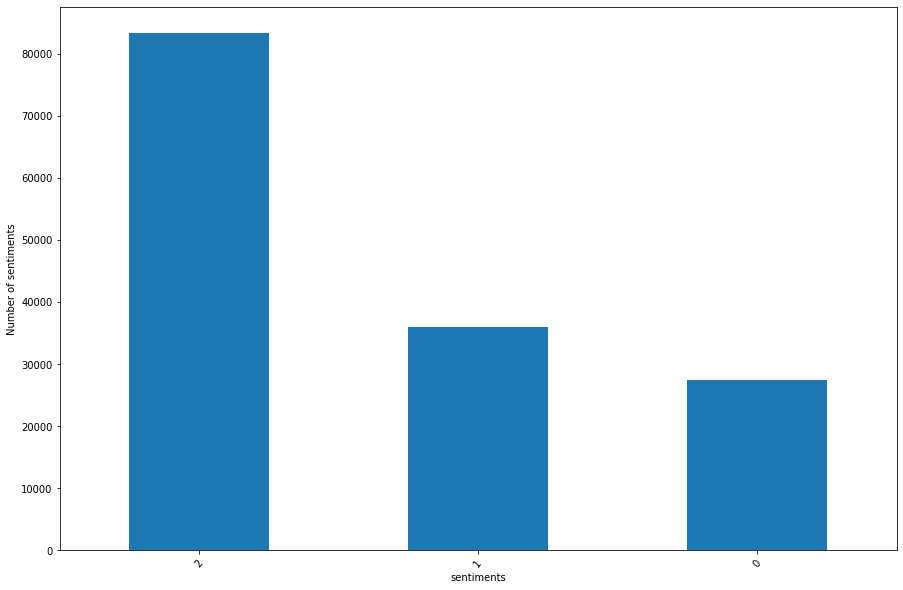

In [8]:
#plot the number of labels with bar chart
label= review_data.groupby("label")
plt.figure(figsize=(15,10))
label.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("sentiments")
plt.ylabel("Number of sentiments")
plt.show()

In [9]:
review_data.groupby('label').describe()

rating                                             
         count      mean       std  min  25%  50%  75%  max
label                                                      
0      27490.0  1.462168  0.498576  1.0  1.0  1.0  2.0  2.0
1      35941.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
2      83380.0  4.497901  0.499999  4.0  4.0  4.0  5.0  5.0

In [10]:
review_data.drop('rating', axis=1, inplace=True)

In [11]:
#label
y= review_data.label
#features
x=review_data.drop('label', axis=1)

In [12]:
review_data.groupby('label').describe()

review                                         
       count unique                         top  freq
label                                                
0      27490  24987   Product quality standards   216
1      35941  28479        Good product quality   550
2      83380  62475   Excellent product quality  1366

In [13]:
#split into test and train dataset with test size 20% 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.head()

,review
14157,Awesome awesome speed of delivery of goods qu...
65865,Fast delivery
40464,Excellent product quality excellent product p...
103718,"Yung quality ... Packaged like their photo, I ..."
1089,Jkvuhhuhggdddff bhhhgghghu hhhhdashgt bbhhhhhh...


In [14]:
x_train.describe()

,review
count,117448
unique,92625
top,Excellent product quality
freq,1077


## WordCloud

In [15]:
#generate wordcloud
review_text_postivie= " ".join (review for review in review_data.review[(review_data['label']== 2)])
print ("There are {} words in the combination of positive review.".format(len(review_text_postivie)))

There are 7421952 words in the combination of positive review.


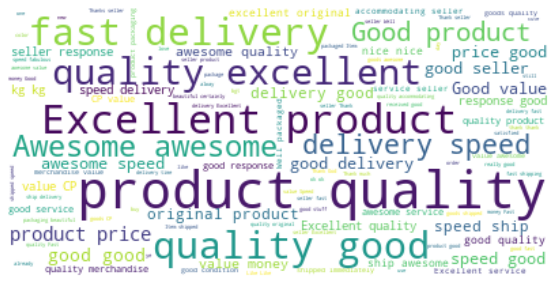

In [16]:
#create stop_word list
stop_words=set(stopwords.words('english'))

#generate a positive word cloud image 
postivie_wordcloud= WordCloud(stopwords=stop_words, background_color="white").generate(review_text_postivie)

#display the generated image
plt.figure(figsize=(10,5))
plt.imshow(postivie_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Neutral Reviews

In [17]:
#generate wordcloud
review_text_neutral= " ".join (review for review in review_data.review[(review_data['label']== 1)])
print ("There are {} words in the combination of neutral review.".format(len(review_text_neutral)))

There are 3090283 words in the combination of neutral review.


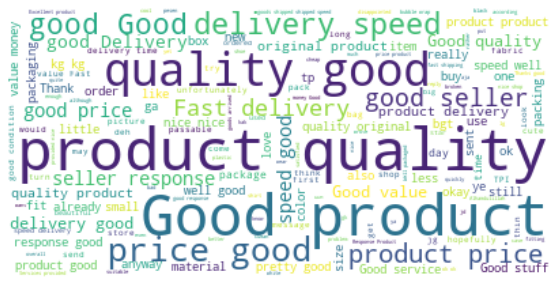

In [18]:
#generate a neutral word cloud image 
neutral_wordcloud= WordCloud(stopwords=stop_words, background_color="white").generate(review_text_neutral)

#display the generated image
plt.figure(figsize=(10,5))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Negative reviews

In [19]:
#generate wordcloud
review_text_negative= " ".join (review for review in review_data.review[(review_data['label']== 0)])
print ("There are {} words in the combination of negative review.".format(len(review_text_negative)))

There are 2576593 words in the combination of negative review.


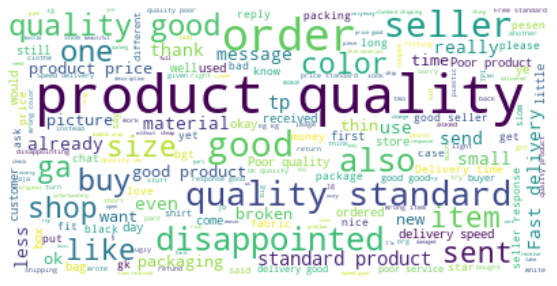

In [20]:
#generate a negative word cloud image 
negative_wordcloud= WordCloud(stopwords=stop_words, background_color="white").generate(review_text_negative)

#display the generated image
plt.figure(figsize=(10,5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Emoji Preprocessing

In [21]:
!pip install emoji

     |████████████████████████████████| 170 kB 34.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=319c520d2a65efbc5572d90a6d022578d601483954b08037a3b294097d4fd90a
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [22]:
import emoji

#Get the dataframe with emoji in review column 
have_emoji_train= []
for i,review in enumerate (x_train['review']):
  if any (char in emoji.UNICODE_EMOJI['es'] for char in review):
    have_emoji_train.append(i) 

In [23]:
print(f'{len(have_emoji_train)} reviews has emojis in train dataset. It means {len(have_emoji_train) / len(x_train) * 100} % from train dataset')

16090 reviews has emojis in train dataset. It means 13.699679858320277 % from train dataset


In [24]:
x_train.iloc[have_emoji_train]

,review
6696,Still good small kok cm bgt😂
140713,Once tried was not able to connect 😏
120558,ga writing plain instead sent kecewaa 😞
82090,I can not buy led side is not nothing but a pa...
55150,Fast Pengirimannyaa skaliii .... tengkyuuuu😍🤗😍
...,...
126898,Excellent quality!!! Well packed!!! Accommodat...
25686,"Her make-up shelf bagussss, elegant plasticity..."
88073,Nice and realpict ... trimakasih 👍
119497,💕💕💕💕💕💕💕💕💕 Morgan 3 kinds of ice crystals and s...


In [25]:
#test dataframe
have_emoji_test= []
for i,review in enumerate (x_test['review']):
  if any (char in emoji.UNICODE_EMOJI['es'] for char in review):
    have_emoji_test.append(i) 

In [26]:
print(f'{len(have_emoji_test)} reviews has emojis in test dataset. It means {len(have_emoji_test) / len(x_test) * 100} % from test dataset')

3958 reviews has emojis in test dataset. It means 13.47954909239519 % from test dataset


* Demojize emoji (change the emoji to text)
* Delete repeated emoji



In [27]:
def emoji_preprocessing(text):

  #demojize 
  #example: Python is :thumbs_up:
  text= emoji.demojize(text).replace (':', ' ')

  #delete repeated emoji 
  tokenize= text.split()
  repeated_list=[]
  for word in tokenize:
    if word not in repeated_list:
      repeated_list.append(word)
    
  
  text=' '.join(word for word in repeated_list)
  text= text.replace("_", " ").replace("-", " ")
  return text

In [28]:
x_train['clean_emoji_text']= x_train['review'].apply(emoji_preprocessing)
x_test['clean_emoji_text']= x_test['review'].apply(emoji_preprocessing)

In [29]:
print("A review example of dataset before cleaning:", end="\n\n")
x_train.iloc[have_emoji_train]['review']

A review example of dataset before cleaning:



6696                           Still good small kok cm bgt😂
140713                 Once tried was not able to connect 😏
120558              ga writing plain instead sent kecewaa 😞
82090     I can not buy led side is not nothing but a pa...
55150        Fast Pengirimannyaa skaliii .... tengkyuuuu😍🤗😍
                                ...                        
126898    Excellent quality!!! Well packed!!! Accommodat...
25686     Her make-up shelf bagussss, elegant plasticity...
88073                    Nice and realpict ... trimakasih 👍
119497    💕💕💕💕💕💕💕💕💕 Morgan 3 kinds of ice crystals and s...
4697                            Nice ... Sellerx friendly 👍
Name: review, Length: 16090, dtype: object

In [30]:
print("clean_emoji_text:")
x_train.iloc[have_emoji_train]['clean_emoji_text']

clean_emoji_text:


6696      Still good small kok cm bgt face with tears of...
140713     Once tried was not able to connect smirking face
120558    ga writing plain instead sent kecewaa disappoi...
82090     I can not buy led side is nothing but a pair b...
55150     Fast Pengirimannyaa skaliii .... tengkyuuuu sm...
                                ...                        
126898    Excellent quality!!! Well packed!!! Accommodat...
25686     Her make up shelf bagussss, elegant plasticity...
88073            Nice and realpict ... trimakasih thumbs up
119497    two hearts Morgan 3 kinds of ice crystals and ...
4697                    Nice ... Sellerx friendly thumbs up
Name: clean_emoji_text, Length: 16090, dtype: object

## Text-preprocessing

In [31]:
#Repeated char function 
def repeated_char(text):
  text = re.sub(r'(\w)\1{2,}',r'\1',text)
  return text

In [32]:
repeated_char_train = []
for i, review in enumerate(x_train['clean_emoji_text']):
  if re.match(r'\w*(\w)\1+',review):
    repeated_char_train.append(i)

In [33]:
len(repeated_char_train)

34345

In [34]:
x_train['clean_text_duplicate']=x_train['clean_emoji_text'].apply(repeated_char)
x_test['clean_text_duplicate']=x_test['clean_emoji_text'].apply(repeated_char)

In [35]:
print("A review example of dataset before cleaning:", end="\n\n")
x_train.iloc[repeated_char_train]['clean_emoji_text']

A review example of dataset before cleaning:



40464     Excellent product quality excellent price is v...
1089      Jkvuhhuhggdddff bhhhgghghu hhhhdashgt bbhhhhhh...
6696      Still good small kok cm bgt face with tears of...
136003    Cool..ang the nice quality of shirt..d cya man...
27912      Excellent quality Well packaged Will order again
                                ...                        
69373     Alhamdulillah package has been sampaiiii ... I...
16578                              Sorry jahitanya neat KRG
8496      Well worth the money package product is very n...
142926                                Good product quality.
3088      Good product quality good price n delivery sel...
Name: clean_emoji_text, Length: 34345, dtype: object

In [36]:
print("A review example of dataset after cleaning:", end="\n\n")
x_train.iloc[repeated_char_train]['clean_text_duplicate']

A review example of dataset after cleaning:



40464     Excellent product quality excellent price is v...
1089      Jkvuhhuhggdff bhgghghu hdashgt bbhjkjhffddghgg...
6696      Still good small kok cm bgt face with tears of...
136003    Cool..ang the nice quality of shirt..d cya man...
27912      Excellent quality Well packaged Will order again
                                ...                        
69373     Alhamdulillah package has been sampai ... Its ...
16578                              Sorry jahitanya neat KRG
8496      Well worth the money package product is very n...
142926                                Good product quality.
3088      Good product quality good price n delivery sel...
Name: clean_text_duplicate, Length: 34345, dtype: object

In [37]:
def NormalizeWithPOS(text):
    # Lemmatization & Stemming according to POS tagging

    #tokenize snetence into a list of single words 
    word_list = word_tokenize(text)
    rev = []
    
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer() 
    
    #pos_tag() get the POS tag of given word 
    #'J'--> Adjective 
    #'V'--> Verb
    #'N'--> Noun
    #'R'--> Adverb 
    
    for word, tag in pos_tag(word_list):
        if tag.startswith('J'):
            w = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemmatizer.lemmatize(word, pos='r')
        else:
            w = word
        w = stemmer.stem(w)
        rev.append(w)
    review = ' '.join(rev)
    return review

In [38]:
def cleanText(text):
    
    #replace some specific words 
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(' +', ' ', text)
    text = text.strip().lower()
   
    if embedding is not 'BERT':
        text = re.sub(r"[0-9]+", ' ', text)
        text = re.sub(r"-", ' ', text)


    if embedding is 'WORD2VEC_NO_STOP':
        #remove stop words 
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any', "n't",
                                              'don', "don't","but",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                                              'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
                                              "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                                              "shan't", 'shouldn',
                                              "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"})
        stop_words = default_stop_words.union({"'m", "'d", "'re", "'s",
                                                  'would','must',"'ve","'ll",'may'})
        word_list=text.split()
        filtered_list=[w for w in word_list if not w in stop_words]
        text=" ".join(filtered_list)



     # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of the sentence detection [,/():;']
        filters='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\?+', '?', text)
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    if embedding is 'BERT':
        text = re.sub(r'\( *\)', ' ', text)

    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    text = ''.join(text)

    return text

Clean Text

In [39]:
embedding=''
x_train['clean_text']= x_train['review'].apply(cleanText)
x_test['clean_text']=x_test['review'].apply(cleanText)

clean text+ normalized+emoji preprocessing

In [40]:
embedding=''
x_train['clean_text_normalized']= x_train['clean_text_duplicate'].apply(cleanText)
x_test['clean_text_normalized']=x_test['clean_text_duplicate'].apply(cleanText)

x_train['clean_text_normalized']=x_train['clean_text_normalized'].apply(NormalizeWithPOS)
x_test['clean_text_normalized']=x_test['clean_text_normalized'].apply(NormalizeWithPOS)

## TF-IDF & CBOW

In [41]:
freq_train= pd.Series(' '.join(x_train['clean_text_normalized']).split()).value_counts()
less_than_five_freq_train= freq_train[(freq_train<5)]
print(less_than_five_freq_train)

cheapo       4
flick        4
receiev      4
sissi        4
strainer     4
            ..
bilan        1
selamanya    1
njebak       1
reresponc    1
vist         1
Length: 30036, dtype: int64


In [42]:
freq_test= pd.Series(' '.join(x_test['clean_text_normalized']).split()).value_counts()
less_than_five_freq_test= freq_test[(freq_test<5)]
print(less_than_five_freq_test)

contract       4
lngganan       4
lil            4
eldest         4
sexi           4
              ..
lemongrass     1
halusnoeren    1
ngkaproblem    1
bagusska       1
soklin         1
Length: 13057, dtype: int64


In [43]:
x_train['clean_text_normalized']= x_train['clean_text_normalized'].apply(lambda x: ' '
.join(x for x in x.split() if x not in less_than_five_freq_train))
x_test['clean_text_normalized']=x_test['clean_text_normalized'].apply(lambda x: ' '
.join(x for x in x.split() if x not in less_than_five_freq_test))

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
embedding = 'TFIDF_WITH_STOP'
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

tfidf_with_stop_training_features = vectorizer.fit_transform(x_train['clean_text_normalized'])    
tfidf_with_stop_test_features = vectorizer.transform(x_test['clean_text_normalized'])

print(tfidf_with_stop_training_features.shape)
print(tfidf_with_stop_test_features.shape)

(117448, 10000)
(29363, 10000)


In [45]:
vocab= vectorizer.fit(x_train['clean_text_normalized'])
vocb= vocab.vocabulary_

In [46]:
import pickle
filename = 'TFIDF_vocab.pkl'
pickle.dump(vocab, open(filename, 'wb'))

## Machine Learning

In [47]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# A function to plot and print result
def printResult(y_pred, y_prob):
    
    acc = accuracy_score(y_test, y_pred)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred, average='weighted')
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred, average='weighted')
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    print("Precision: {:.2f}".format(precision*100),end='\n\n')
    print("Recall: {:.2f}".format(recall*100),end='\n\n')
    print("F1-Score: {:.2f}".format(f1*100),end='\n\n')
    cm = confusion_matrix (y_test,y_pred)
    #print('Confusion Matrix:\n', cm)
    print(classification_report(y_test,y_pred))
    classNames = ['negative', 'neutral', 'positive'] 
    plot_confusion_matrix(cm, classNames)

In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
model3= LogisticRegression(C=0.1, multi_class="multinomial",solver='sag')

TF-IDF LR with stop words

In [50]:
# Training 
model3.fit(tfidf_with_stop_training_features, y_train)

# Evaluation
y_pred_lr_stop_tfidf = model3.predict(tfidf_with_stop_test_features)
y_prob_lr_stop_tfidf = model3.decision_function(tfidf_with_stop_test_features)

Accuracy: 76.75

Precision: 75.70

Recall: 76.75

F1-Score: 75.64

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      5500
           1       0.66      0.47      0.55      7059
           2       0.81      0.91      0.86     16804

    accuracy                           0.77     29363
   macro avg       0.73      0.70      0.71     29363
weighted avg       0.76      0.77      0.76     29363



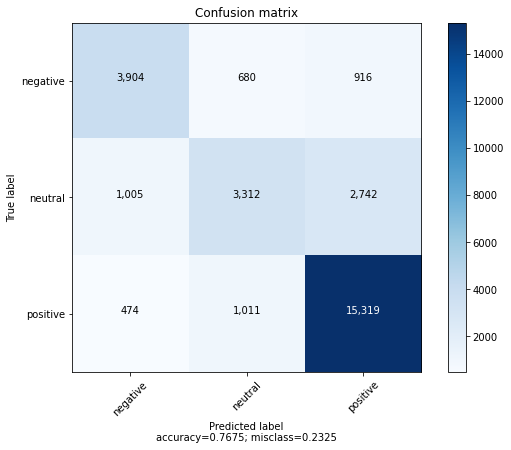

In [51]:
# Result
printResult(y_pred_lr_stop_tfidf,y_prob_lr_stop_tfidf)

In [52]:
#import pickle
#from google.colab import files

filename = 'TFIDF_LR_model.pkl'
pickle.dump(model3, open(filename, 'wb'))

In [53]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(C=0.1, multi_class="multinomial",solver='sag'))
])

In [54]:
#test datafile 
review_test = pd.read_csv("/content/gdrive/My Drive/Shopee Review Data/test.csv", index_col=0)
#review_data = pd.read_csv(r"D:\University\FYP\ShopeeProductReviewsSentimentAnalysis\Shopee Reviews Data\train.csv", index_col=0)
review_test = review_test.sample(frac=1)
review_test.head()

,review
review_id,
41372,Already receved. Package to order. Shipping ok...
29700,Reebok always has some styles available .
19347,Never disappoints. Thank God all the same cust...
39567,Messages sent her any more attetion what next ...
14652,"Has been used successfully, it stores pack the..."


In [55]:
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

test_features = vectorizer.transform(review_test['review'])

print(test_features.shape)

(60427, 10000)


In [56]:
prediction =model3.predict(test_features)

In [57]:
review_test['Rating'] = prediction

In [58]:
review_test

,review,Rating
review_id,,
41372,Already receved. Package to order. Shipping ok...,2
29700,Reebok always has some styles available .,0
19347,Never disappoints. Thank God all the same cust...,2
39567,Messages sent her any more attetion what next ...,0
14652,"Has been used successfully, it stores pack the...",2
...,...,...
41534,"Exposes you to review this sp good buy, but go...",2
4146,she ... okay no problem to me ... is affordabl...,2
44134,Decent pair of shoes .,2


In [59]:
review_test.groupby('Rating').describe()

review                                                               
        count unique                                                top freq
Rating                                                                      
0        9232   9099  Very comfortable even though I am not a trail ...    7
1        6533   6472  I would n't wear these on sidewalks / asphalt ...    6
2       44662  42140                                 Very comfortable .  128

In [60]:
def sentiment(df):
  if (df['Rating']==0):
    return "negative"
  elif (df['Rating']==1):
    return "neutral"
  else:
    return "positive"

In [61]:
review_test['sentiment']= review_test.apply(sentiment, axis=1)
review_test

,review,Rating,sentiment
review_id,,,
41372,Already receved. Package to order. Shipping ok...,2,positive
29700,Reebok always has some styles available .,0,negative
19347,Never disappoints. Thank God all the same cust...,2,positive
39567,Messages sent her any more attetion what next ...,0,negative
14652,"Has been used successfully, it stores pack the...",2,positive
...,...,...,...
41534,"Exposes you to review this sp good buy, but go...",2,positive
4146,she ... okay no problem to me ... is affordabl...,2,positive
44134,Decent pair of shoes .,2,positive


In [62]:
review_test.to_csv('review_prediction.csv')

## **Dash Board**

In [63]:
! pip install jupyter-dash

     |████████████████████████████████| 7.3 MB 34.8 MB/s 
     |████████████████████████████████| 23.9 MB 14 kB/s 
     |████████████████████████████████| 357 kB 45.4 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=815f5e7cb9066ddfc62d2e1dfb5316eb11b5306c1eae613fad7586528ecc5ee0
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=5432e42779d38f0b3cb0b79d30268b57ea8e2a7546ea5d0c6beef0bdacbfee3a
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=a8a49dd1b1ff81fd38c32e93c357c033fd3e0ee94a7ffb016097ef2ea53d5498
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aef

In [64]:
! pip install dash-bootstrap-components

     |████████████████████████████████| 207 kB 26.9 MB/s 


In [65]:
#import plotly.express as px
from jupyter_dash import JupyterDash
import plotly.graph_objects as go
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State
import dash_bootstrap_components as dbc

In [66]:
# # Build App
# app = JupyterDash(__name__, title='Sentiment Analysis with Insights',
#            update_title='Loading...', external_stylesheets=[dbc.themes.BOOTSTRAP])

# colors = {
#     'background': '#FFFFFF',
#     'text': '#ED3C2B'
# }

# pie_colors = ['#B70000', '#ED3C2B', '#DB5639']

# app.layout= html.Div(style={'backgroundColor': colors['background']}, children=[
    
#     html.H1(
#         id="heading1",
#         children='Sentiment Analysis for Shopee Product Reviews',
#         style={
#             'textAlign': 'center',
#             'color': colors['text'],
#             'font': 'sans-seriff',
#             'font-weight': 'bold',
#             'font-size': '30px'
            
#         }
#     ),
#     html.Div([
#               dcc.Upload(
#                   id='upload-data',
#                   children=html.Div([
#             'Drag and Drop or ',
#             html.A('Select Files')
#         ]),
#         style={
#              'width': '100%',
#             'height': '60px',
#             'lineHeight': '60px',
#             'borderWidth': '1px',
#             'borderStyle': 'dashed',
#             'borderRadius': '5px',
#             'textAlign': 'center',
#             'margin': '10px'
#         },
#               )
#     ]),
#     html.P(
#         children= "Sentiment Prediction of Product Reviews",
#         style={
#             'textAlign': 'center',
#             'color': colors['text'],
#             'font': 'sans-seriff',
#             'font-weight': 'bold',
#             'font-size': '20px'
#         }
#     ),
#         dbc.Container(
#                         dcc.Loading(
#                             dcc.Graph(
#                                 id="pie_chart",
#                                 # figure={'data': [go.Pie(labels=review_test['sentiment'].value_counts().index, values=review_test['sentiment'].value_counts().values, hole=.3, pull=[0.2, 0, 0], textinfo='value', marker=dict(colors= pie_colors))],
#                                 #         'layout': go.Layout(autosize=True)
#                                 #        }
#                             )
#                         )
#         )
#             ])

# def parse_data(contents,filename):
#   content_type, content_string= contents.split(',')
#   decoded = base64.b64decode(content_string)

#   try:
#       if 'csv' in filename:
#           # Assume that the user uploaded a CSV or TXT file
#           df = pd.read_csv(
#               io.StringIO(decoded.decode('utf-8')))
#       elif 'xls' in filename:
#           # Assume that the user uploaded an excel file
#           df = pd.read_excel(io.BytesIO(decoded))
#       elif 'txt' or 'tsv' in filename:
#           # Assume that the user upl, delimiter = r'\s+'oaded an excel file
#           df = pd.read_csv(
#                 io.StringIO(decoded.decode('utf-8')), delimiter = r'\s+')
  
#   except Exception as e:
#         print(e)
#         return html.Div([
#         'There was an error processing this file.'
#         ])

#   print(df)
#   return df

# @app.callback(Output('pie_chart', 'figure'),
#             [
#                 Input('upload-data', 'contents'),
#                 Input('upload-data', 'filename'),
#             ])

# def Udpate_graph(contents, filename):

#   fig= {
#       'layout': go.Layout(autosize=True)
#   }
#   if contents:
#         contents = contents[0]
#         filename = filename[0]
#         df= parse_data(contents, filename)
#         test_features = vectorizer.transform(df['review'])
#         prediction =model3.predict(test_features)
#         df['Rating'] = prediction
#         df['sentiment']= df.apply(sentiment, axis=1)

#   fig['data']= go.Pie(labels=df['sentiment'].value_counts().index, values=df['sentiment'].value_counts().values, hole=.3, pull=[0.2, 0, 0], 
#                                textinfo='value', marker=dict(colors= pie_colors))
                                        
#   return fig


In [68]:
import base64
import datetime
import io

from jupyter_dash import JupyterDash
from dash import no_update
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import dash_table
#import plotly.express as px

# Build App
app = JupyterDash(__name__, 
                suppress_callback_exceptions=True)

colors = {
    'background': '#FFFFFF',
    'text': '#ED3C2B'
}

pie_colors = ['#B70000', '#ED3C2B', '#DB5639']

def sentiment(df):
  if (df['Rating']==0):
    return "negative"
  elif (df['Rating']==1):
    return "neutral"
  else:
    return "positive"

app.layout = html.Div([ # this code section taken from Dash docs https://dash.plotly.com/dash-core-components/upload
    dcc.Upload(
        id='upload-data',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.P(
        children= "Sentiment Prediction of Product Reviews",
        style={
            'textAlign': 'center',
            'color': colors['text'],
            'font': 'sans-seriff',
            'font-weight': 'bold',
            'font-size': '20px'
        }
    ),
    html.Div(id='output-div'),
    html.Div(id='output-datatable'),
   
])



def parse_contents(contents, filename, date):
    content_type, content_string = contents.split(',')

    decoded = base64.b64decode(content_string)
    try:
        if 'csv' in filename:
            # Assume that the user uploaded a CSV file
            df = pd.read_csv(
                io.StringIO(decoded.decode('utf-8')))
        elif 'xls' in filename:
            # Assume that the user uploaded an excel file
            df = pd.read_excel(io.BytesIO(decoded))
    except Exception as e:
        print(e)
        return html.Div([
            'There was an error processing this file.'
        ])

    test_features = vectorizer.transform(df['review'])
    prediction =model3.predict(test_features)
    df['Rating'] = prediction
    df['sentiment']= df.apply(sentiment, axis=1)

    return html.Div([
        html.H5(filename),
        html.H6(datetime.datetime.fromtimestamp(date)),
        html.Button(id="submit-button", children="Create Graph"),
        html.Hr(),

        dash_table.DataTable(
            
            data=df.to_dict('records'),
            columns=[{'name': i, 'id': i} for i in df.columns],
            page_size=15
            
        ),
        dcc.Store(id='stored-data', data=df.to_dict('records')),
        
        html.Hr(),  # horizontal line

        # For debugging, display the raw contents provided by the web browser
        html.Div('Raw Content'),
        html.Pre(contents[0:200] + '...', style={
            'whiteSpace': 'pre-wrap',
            'wordBreak': 'break-all'
        })
    ])


@app.callback(Output('output-datatable', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'),
              State('upload-data', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children

@app.callback(Output('output-div', 'children'),
              Input('submit-button','n_clicks'),
              State('stored-data','data'),
              
              )
def make_graphs(n,data):
    if n is None:
        return no_update
    else:
        df=pd.DataFrame(data)
        return    dcc.Graph(
                                id="pie_chart",
                                figure={'data': [go.Pie(labels=df['sentiment'].value_counts().index, values=df['sentiment'].value_counts().values, hole=.3, pull=[0.2, 0, 0], textinfo='value', marker=dict(colors= pie_colors))],
                                        'layout': go.Layout(autosize=True)
                                       }
                            )
        
        




In [69]:
# Run app and display result inline in the notebook
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>